In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import xrayutilities as xu
import Dans_Diffraction as dif
from functions import shift_atoms_p65, transform_list_hkl_p63_p65, get_structure_factors, get_mode_amplitudes_p65
from matplotlib.markers import MarkerStyle
from tqdm import tqdm
from time import time

%config InlineBackend.figure_format = 'svg' # make figures appears in .svg style


num_threads = 2  

# Configure TensorFlow to use multiple threads
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.threading.set_inter_op_parallelism_threads(num_threads)

print(f"Using {num_threads} threads for intra-op and inter-op parallelism.")


Using 2 threads for intra-op and inter-op parallelism.


Define the function containing the fitting parameters

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- `fun_tf()` correspond to the **structure factor calculation function** (one has to convert it to a **TF-compatible** function)
- <span style="color:red">If conversion to TF-compatible function is not possible, then this approach will probably not work (or becomes much more tedious at least)</span>

In [2]:
def fun_tf(x, pars):
    """
    Fast computation of structure factors with parameter-dependent structure.    
    """
    # Get modified structure
    modified_struct = shift_atoms_p65(*pars)
    neg_h = tf.stack([-x[:, 0], x[:, 1], x[:, 2]], axis=1)
    x_combined = tf.concat([x, neg_h], axis=0)  # Shape [2N, 3]

    x_combined = transform_list_hkl_p63_p65(x_combined)

    # Get structure factors
    sf_combined = get_structure_factors(x_combined, modified_struct)
    # Compute intensity
    # Split and compute intensity
    sf_hkl = sf_combined[:tf.shape(x)[0]]
    sf_neg_k = sf_combined[tf.shape(x)[0]:]
    
    intensity = (tf.abs(sf_hkl) + tf.abs(sf_neg_k)) ** 2
    return intensity / tf.reduce_max(intensity)


In [3]:
# Example input data
x_example = np.array([[0.25, 0.25, 1.5], [-0.25, 0.25, 1.5], [0.75, 0.25, 1.5], [-0.75, 0.25, 1.5] ], dtype=np.float32)
# Convert to TensorFlow tensors
x_example_tf = tf.convert_to_tensor(x_example)

pars_example = np.array([-0.00001487,-0.00295681, 0.00002191, -0.00001591, 0.00854070, 0.00852493], dtype=np.float32)

pars_example_tf = tf.convert_to_tensor(pars_example)

# Call the function with the example data
result = fun_tf(x_example_tf, pars_example_tf)
# Print the result
tf.print("example hkl:", x_example_tf)
tf.print("example hkl in parent cell:", transform_list_hkl_p63_p65(x_example_tf))
tf.print("example pars:", pars_example_tf)
tf.print("Result:", result)

example hkl: [[0.25 0.25 1.5]
 [-0.25 0.25 1.5]
 [0.75 0.25 1.5]
 [-0.75 0.25 1.5]]
example hkl in parent cell: [[3 -1 0]
 [3 -0 -0.5]
 [3 -2 0.5]
 [3 1 -1]]
example pars: [-1.487e-05 -0.00295681 2.191e-05 -1.591e-05 0.0085407 0.00852493]
Result: [0.449857712 0.449857712 1 1]


Sample the model parameters (fitting parameters)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The six parameters correspond to the fractional atomic shifts in the modes w.r.t. unit cell lengths

In [4]:
experimental_data = pd.read_csv('/home/mariolb/repos/CrystalClearFit/DistortionFit/combined.csv')
hkl_list = experimental_data[["h", "k", "l"]].values.tolist()
print(experimental_data.shape)
print(hkl_list[0:5])

(910, 17)
[[-0.5, -0.5, 0.0], [0.5, -0.5, 0.0], [-1.5, -0.5, 0.0], [1.5, -0.5, 0.0], [-2.5, -0.5, 0.0]]


Sample the "training data" (features and labels)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The features are the (h,k,l) coordinates (e.g. a vector of size `n_features` x 3, i.e. `n_dim = 3`)
- Maybe one has to normalize the features (i.e. not using integers but floats between -1 (0) and 1)? Before passing them to the structure calculation function, they should be again rescaled to integers
- The labels would be the experimental intensities (again, maybe have to be normalized to the range between 0 and 1)

In [5]:
n_features = 910
n_dim = 3
hkl_list = np.array(hkl_list, dtype=np.float32)
hkl_chosen = hkl_list[np.random.choice(hkl_list.shape[0], n_features, replace=False)]
features = tf.convert_to_tensor(hkl_chosen, dtype=tf.float32)

example_distortion = np.array([0.065, 0.0, 0.0, 0.0, 0.0, 0.025], dtype=np.float32)
"""
xtl = dif.Crystal('P65_giant_cell.cif')
labels = []
for hkl in hkl_chosen:
    p_hkl = np.array([2*hkl[2], -2*(hkl[0]+hkl[1]), hkl[0]- hkl[1]])
    n_hkl = np.array([2*hkl[2], -2*(-1*hkl[0]+hkl[1]), -1*hkl[0]- hkl[1]])
    sf_p = xtl.Scatter.intensity(p_hkl, scattering_type='xray', energy_kev=73, temperature=673)[0]
    sf_n = xtl.Scatter.intensity(n_hkl, scattering_type='xray', energy_kev=73, temperature=673)[0]
    labels.append(np.abs(sf_p)**2 + np.abs(sf_n)**2)
"""
crys = xu.materials.Crystal.fromCIF('P65_giant_cell.cif')
labels = []
for hkl in hkl_chosen:
    p_hkl = np.array([2*hkl[2], -2*(hkl[0]+hkl[1]), hkl[0]- hkl[1]])
    n_hkl = np.array([2*hkl[2], -2*(-1*hkl[0]+hkl[1]), -1*hkl[0]- hkl[1]])
    sf_p = crys.StructureFactor(p_hkl, en=73000, temp=673)
    sf_n = crys.StructureFactor(n_hkl, en=73000, temp=673)
    labels.append(np.abs(sf_p)**2 + np.abs(sf_n)**2)

   
labels = labels / np.max(labels)
lables = tf.convert_to_tensor(labels, dtype=tf.float32)
print(labels[0:5])
combined_labels = tf.stack([labels, tf.ones((labels.shape[0]), dtype=tf.float32)], axis=1)
print("Features shape:", features.shape)
print("Labels shape:", combined_labels.shape)
print(combined_labels[0:5])


XU.materials: Warning: element Pr used instead of Pr+3
XU.materials: Warning: element Pr used instead of Pr+3
XU.materials: Warning: element O used instead of O-2
XU.materials: Warning: element O used instead of O-2
XU.materials: Warning: element Ni used instead of Ni+1
XU.materials: Warning: element Ni used instead of Ni+1
XU.materials: Warning: element Ni used instead of Ni+1


TypeError: 'Crystal' object is not iterable

Define a simple model

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The six parameters (a,b,c,d,e,f) correspond to the fractional atomic shifts in the modes w.r.t. unit cell lengths
- Instead of `sigmoid`, `tanh` should be applied to the parameters before passing them to the structure factor calculation function (ensures smoother gradient landscape)
- The `tanh` function can furthermore be limited to a specific range (e.g. if atomic distortions should not exceed +- 0.1)

In [ ]:
class FunAsLayer(tf.keras.layers.Layer):
    def __init__(self, max_par_value=0.01, **kwargs):
        super().__init__(**kwargs)
        self.max_par_value = max_par_value

    def build(self, input_shape):
        # Define six trainable parameters
        self.a = self.add_weight(name='a', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.b = self.add_weight(name='b', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.c = self.add_weight(name='c', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.d = self.add_weight(name='d', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.e = self.add_weight(name='e', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.f = self.add_weight(name='f', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        # Apply tanh to ensure parameters stay within the range
        a = self.max_par_value * tf.tanh(self.a)
        b = self.max_par_value * tf.tanh(self.b)
        c = self.max_par_value * tf.tanh(self.c)
        d = self.max_par_value * tf.tanh(self.d)
        e = self.max_par_value * tf.tanh(self.e)
        f = self.max_par_value * tf.tanh(self.f)
        
        # Call your fun_tf function to get the output
        return fun_tf(inputs, [a, b, c, d, e, f])

    def compute_output_shape(self, input_shape):
        # If the input has shape (None, 3), return the same shape
        return (input_shape[0], 1)  # This assumes your output is of shape (None, 1)


Create optimizer and define loss function

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The learning rate must be determined by experimentation (same holds for the batch size and the number of epochs below)
- As a loss function, one can try either MSE or R-score (MSE seems to be the more "natural choice" in this case)

In [ ]:
 # mean squared error
class PerSampleMSE(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__(reduction=tf.keras.losses.Reduction.NONE)

    def call(self, y_true, y_pred):
        squared_error = tf.square(y_true - y_pred)
        per_sample_mse = tf.reduce_mean(squared_error, axis=-1)
        return per_sample_mse  # shape (batch_size,)

class MSE_weighted(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        # Assume y_true = [labels, errors]
        labels = y_true[:, 0]
        weights = y_true[:, 1]

        mse = tf.square(labels - y_pred)
        return tf.reduce_sum(mse * weights) / tf.reduce_sum(weights)

# Define the custom loss function   
class R_factor(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        # Assume y_true = [labels, errors]
        labels = y_true[:, 0]
        weights = y_true[:, 1]

        r_factor = tf.reduce_sum(tf.abs(labels**.5 - y_pred**.5)) / tf.reduce_sum(labels**.5)
        return r_factor


# Define the custom metric function
def r_factor_metric(y_true, y_pred):
    labels = y_true[:, 0]
    return tf.reduce_sum(tf.abs(labels**.5 - y_pred**.5)) / tf.reduce_sum(labels**.5)


Train the model for n iterations (to try different initial weights)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The number of iterations defines the "starting position" $w_0$ of the gradient descent algorithm
- Because there are probably many local minima, changing $w_0$ allows the algorithm to find different minima and increases the chances of finding the global minima

Learning rate: 0.008
Final loss: 3.895e-01
Iteration 1 - New best loss: 3.895e-01 (R-factor: 0.38952457904815674)
Final loss: 3.706e-01
Iteration 2 - New best loss: 3.706e-01 (R-factor: 0.3705793023109436)
Final loss: 1.099e+00
Final loss: 6.118e-01
Final loss: 3.704e-01
Iteration 5 - New best loss: 3.704e-01 (R-factor: 0.3703726828098297)
Final loss: 6.220e-01
Final loss: 5.940e-01
Final loss: 4.006e-01
time elapsed: 98.07 seconds
With 65.25812592896068 iterations per second


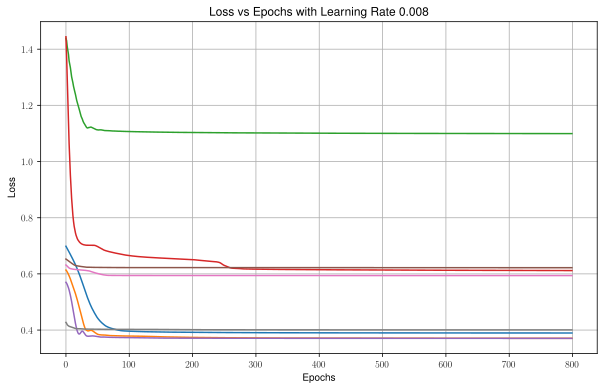

Learning rate: 0.01
Final loss: 3.917e-01
Iteration 1 - New best loss: 3.917e-01 (R-factor: 0.39169973134994507)
Final loss: 9.864e-01
Final loss: 5.945e-01
Final loss: 3.916e-01
Iteration 4 - New best loss: 3.916e-01 (R-factor: 0.3915955424308777)
Final loss: 5.940e-01
Final loss: 6.016e-01
Final loss: 6.183e-01
Final loss: 3.999e-01
time elapsed: 110.04 seconds
With 58.15996912035555 iterations per second


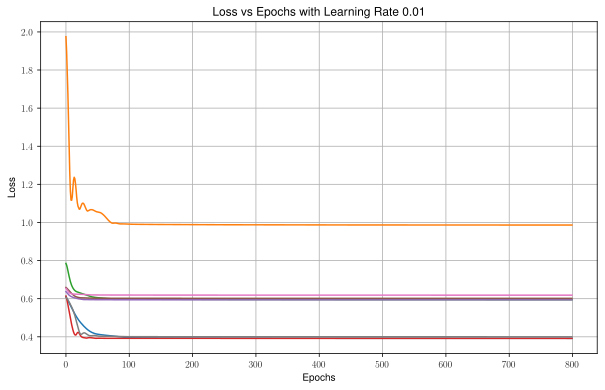

In [ ]:
lr = [8e-3, 1e-2]
best_pars_overall = None
best_rf_overall = np.inf
best_loss_overall = []
for learning_rate in lr:
    time_start = time()
    print(f"Learning rate: {learning_rate}")
    optim = tf.keras.optimizers.Adam(learning_rate=learning_rate)


    max_par_value = 0.066
    n_epochs = 800
    histories = []
    n_iter = 8

    min_loss = np.inf
    best_pars = None

    # List to store the loss values for each epoch
    all_losses = []


    for i in range(n_iter):
        # Create the model
        inputs = tf.keras.Input(shape=(n_dim,))
        outputs = FunAsLayer(max_par_value)(inputs)
        model = tf.keras.Model(inputs, outputs)

        # Compile the model with the custom loss function and metric
        model.compile(
            optimizer=optim,
            loss=R_factor(), # MSE_weighted() if using errors
            metrics=[r_factor_metric]
        )
        
        history = model.fit(
        x=features,
        y=combined_labels,  # replace with combined_labels if using errors
        batch_size = features.shape[0], # Use a smaller batch size features.shape[0]
        epochs=n_epochs,
        verbose=0,
        shuffle=True, # not sure whether this matters
        # callbacks=[cb]
        )

        histories.append(history)
        all_losses.append(history.history['loss'])
        # Check final loss
        final_loss = history.history['loss'][-1]
        curren_model_pars = [max_par_value * tf.tanh(model.layers[-1].get_weights()[i]) for i in range(6)]
        print(f"Final loss: {final_loss:.3e}")
        '''
        print(f"Best parameters for iteration {i+1}:")
        for j, par in enumerate(curren_model_pars):
            print(f"Parameter {j+1}: {par.numpy():.4f}")
        '''

        if final_loss < min_loss:
            # Update best model parameters
            best_model_pars = [max_par_value * tf.tanh(model.layers[-1].get_weights()[i]) for i in range(6)]
            min_loss = final_loss
            rf = r_factor_metric(combined_labels, fun_tf(features, best_model_pars))
            print(f"Iteration {i+1} - New best loss: {min_loss:.3e} (R-factor: {rf})")

    if min_loss < best_rf_overall:
        best_rf_overall = min_loss
        best_pars_overall = best_model_pars
        best_loss_overall = all_losses
    print(f"time elapsed: {time() - time_start:.2f} seconds")
    print(f"With {n_epochs*n_iter /(time() - time_start)} iterations per second")
    # Plotting the loss values
    plt.figure(figsize=(10, 6))

    # Plot the loss values for each iteration
    for i, loss_values in enumerate(all_losses):
        plt.plot(loss_values, label=f'Iteration {i+1}')

    plt.title(f'Loss vs Epochs with Learning Rate {learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # plt.legend()
    plt.grid(True)
    plt.show()


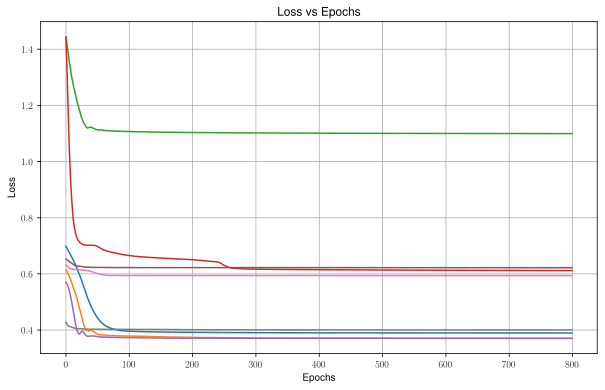

In [ ]:
all_losses = best_loss_overall
best_model_pars = best_pars_overall
min_loss = best_rf_overall

# Plotting the loss values
plt.figure(figsize=(10, 6))

# Plot the loss values for each iteration
for i, loss_values in enumerate(all_losses):
    plt.plot(loss_values, label=f'Iteration {i+1}')

plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Print the best model parameters
print("Best model parameters:")
for i, par in enumerate(best_model_pars):
    print(f"Parameter {i+1}: {par.numpy():.8f}")
    
# Print the model summary
print("Maximum parameter value:", max_par_value)
print("Number of iterations:", n_iter)
print("Number of features:", features.shape[0])
model.summary()
modes = get_mode_amplitudes_p65(*best_model_pars)
print("Modes:")
for key, val in modes.items():
    print(f"{key}: {val*1000:.4f}")

Best model parameters:
Parameter 1: -0.06352751
Parameter 2: 0.06584404
Parameter 3: -0.06599746
Parameter 4: 0.06580502
Parameter 5: -0.06544901
Parameter 6: -0.02388869
Maximum parameter value: 0.066
Number of iterations: 8
Number of features: 910
Model: "model_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_95 (InputLayer)       [(None, 3)]               0         
                                                                 
 fun_as_layer_94 (FunAsLayer  (None,)                  6         
 )                                                               
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
Modes:
S1(a,0;0,0)[Pr1:d:dsp]A2u(a): -63.5275
S1(a,0;0,0)[O1:f:dsp]B3u(a): -0.1013
S1(a,0;0,0)[O1:f:dsp]B2u(a): 0.5875
M1+(a)[O1:f:dsp]B2u(a): -

In [ ]:
def plot_plane_sim_vs_exp(ax, df, l, norm_plane=False):
    exp_data_0 = df.loc[df['l'] == l].copy()
    if norm_plane:
        exp_data_0['intensity_sim'] = exp_data_0['intensity_sim'] / np.max(exp_data_0['intensity_sim'])
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.max(exp_data_0['intensity_exp'])
    
    ax.scatter(exp_data_0['h'], -exp_data_0['k'], 
               s=exp_data_0['intensity_sim'] * 300, color='red', edgecolor="black",
               label='Sim', marker=MarkerStyle("o", fillstyle="left"))
    ax.scatter(exp_data_0['h'], -exp_data_0['k'], 
               s=exp_data_0['intensity_exp'] * 300, color='blue', edgecolor="black",
               label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    
    ax.set_xlabel(f"h in (h, k, {l}) [r.l.u.]")
    ax.set_ylabel(f"k in (h, k, {l}) [r.l.u.]")
    ax.set_title(f"l = {l}")
    ax.legend()

In [ ]:
dataframe = pd.DataFrame(hkl_chosen, columns=["h", "k", "l"])
dataframe["intensity_exp"] = labels
dataframe["intensity_sim"] = fun_tf(features, best_model_pars).numpy()

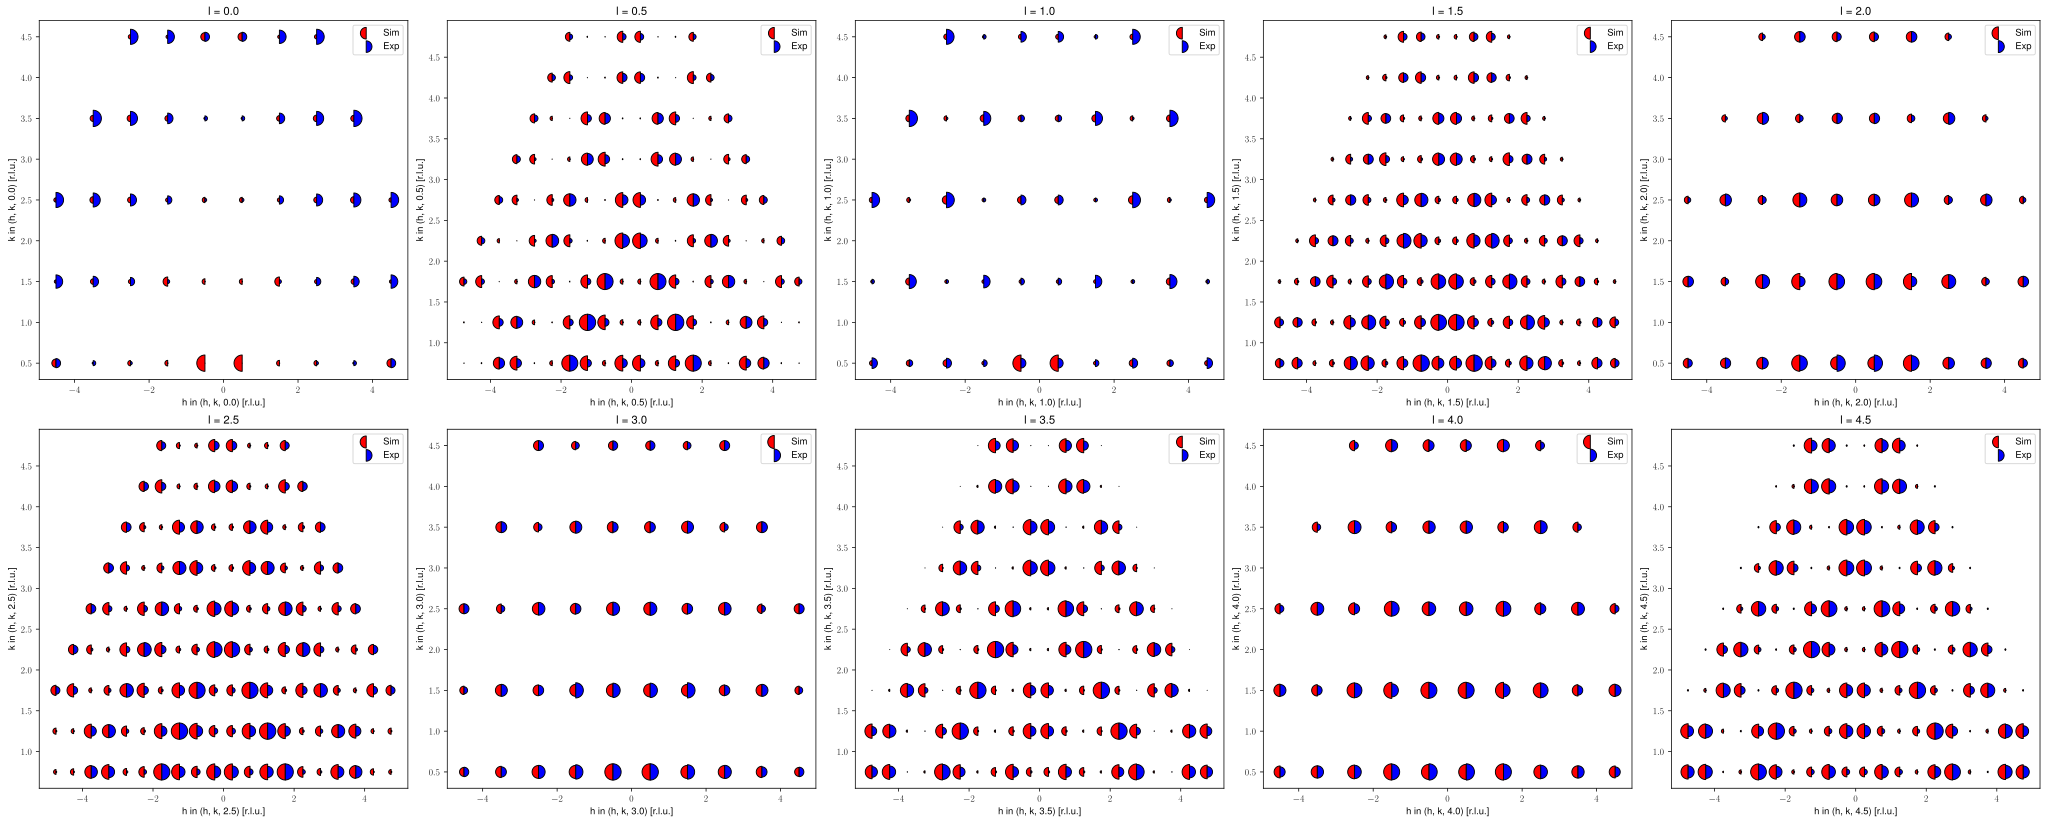

In [ ]:
# Prepare subplot grid
l_values = np.arange(0, 5, 0.5)
n = len(l_values)
ncols = int(np.ceil(n / 2))
fig, axs = plt.subplots(2, ncols, figsize=(6 * ncols, 12), constrained_layout=True)

# Flatten axs in case it's 2D array
axs = axs.flatten()

plt.style.use('default')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# Plot all subplots
for i, l in enumerate(l_values):
    plot_plane_sim_vs_exp(axs[i], dataframe, l, norm_plane=True)

plt.show()